<h2 style='text-align:center'>Hyperparameter Tuning</h2>

<hr>

In [101]:
# imprt libraries
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold 
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

In [102]:
#Data Preprocessing

def preprocess(dataset:pd.DataFrame) -> pd.DataFrame :
    '''
    dataset contain this columns:
        'gender':               ['Female' 'Male']
        'SeniorCitizen':        [0 1]
        'Partner':              ['Yes' 'No']
        'Dependents':           ['No' 'Yes']
        'tenure':               int
        'PhoneService':         ['No' 'Yes']
        'MultipleLines':        ['No phone service' 'No' 'Yes']
        'InternetService':      ['DSL' 'Fiber optic' 'No']
        'OnlineSecurity':       ['No' 'Yes' 'No internet service']
        'OnlineBackup':         ['Yes' 'No' 'No internet service']
        'DeviceProtection':     ['No' 'Yes' 'No internet service']
        'TechSupport':          ['No' 'Yes' 'No internet service']
        'StreamingTV':          ['No' 'Yes' 'No internet service']
        'StreamingMovies':      ['No' 'Yes' 'No internet service']
        'Contract':             ['Month-to-month' 'One year' 'Two year']
        'PaperlessBilling':     ['Yes' 'No']
        'PaymentMethod':        ['Electronic check' 'Mailed check' 'Bank transfer (automatic)' 'Credit card (automatic)']
        'MonthlyCharges':       float
        'TotalCharges':         float
        'Churn':                ['No' 'Yes']   // Not necessary
    '''
    df = dataset.copy()

    # Prepare string variables
    df.columns = df.columns.str.lower().str.replace(' ','_')
    string_columns = list(df.dtypes[df.dtypes=='O'].index)
    for col in string_columns:
        df[col] = df[col].str.lower().str.replace(' ','_')

    # drop customerid
    if 'customerid' in df.columns:
        del df['customerid']
        
    # Prepare numeric columns type
    if 'tenure' in df.columns:
        df['tenure'] = pd.to_numeric(df['tenure'], errors='coerce')
        df['tenure'] = df['tenure'].fillna(0)
    else:
        raise Exception("!!! Tenure column didn't exist !!!")

    if 'monthlycharges' in df.columns:
        df['monthlycharges'] = pd.to_numeric(df['monthlycharges'], errors='coerce')
        df['monthlycharges'] = df['monthlycharges'].fillna(0)
    else:
        raise Exception("!!! MonthlyCharges column didn't exist !!!")

    if 'totalcharges' in df.columns:
        df['totalcharges'] = pd.to_numeric(df['totalcharges'], errors='coerce')
        df['totalcharges'] = df['totalcharges'].fillna(0)
    else:
        raise Exception("!!! TotalCharges column didn't exist !!!")
        
    # Make dependent variable numeric
    if 'churn' in df.columns:
        df.churn = (df.churn == 'yes').astype(int)
    
    return df

In [103]:
# Feature Engineering

def FeatureEngineering(dataset:pd.DataFrame,
                       categorical_variables:list,
                       numerical_variables:list,
                       isTrain:bool,
                       scaleColumns:list):
    """
    dataset: pd.Dataframe
    categorical_variables: list of important categorical columns that we want to use in pur model
    numerical_variables: list of important numerical columns that we want to use in pur model
    isTrain:    if you want to train a model, set it 'True'
                if you want to use for test or deployment set it 'False'
    """
    df = dataset.copy()
    categorical_important = categorical_variables.copy()
    numerical_important = numerical_variables.copy()
    df = df[numerical_important + categorical_important]

    # we create a folder to save our data there 
    path = os.getcwd()
    assets_path = path+'\\assets'
    if not os.path.exists(assets_path):
        os.makedirs(assets_path)

    # Dummy variables
    if isTrain:
        def ohe(dataset:pd.DataFrame, categorical_columns:str):
            df = dataset.copy()
            df_info = pd.DataFrame(columns=['col', 'uniques'])
            for col in categorical_columns:
                list_Uniques = df[col].unique()
                df_info.loc[len(df_info)] = [col, ','.join(map(str, list_Uniques))]
                for name in list_Uniques:
                    df[str(col)+'_'+str(name)] = df[col].apply(lambda x : 1 if x==name else 0)
                del df[col]

            df_info.to_csv(assets_path+'\\ohe_info.csv', index=False)
            return df

        df=ohe(df, categorical_important)
    else:
        df_info = pd.read_csv(assets_path+'\ohe_info.csv')
        for i in range(len(df_info)):
            col = df_info.iloc[i,:].col
            list_Uniques = df_info.iloc[i,:].uniques.split(',')
            for name in list_Uniques:
                df[str(col)+'_'+str(name)] =  df[col].apply(lambda x : 1 if x==name else 0)
            del df[col]

    # Feature scaling
    if isTrain:
        scale_info = pd.DataFrame(columns=['col','mean','std'])
        for col in scaleColumns:
            mean_col = df[col].mean()
            std_col = df[col].std()
            df[col] = (df[col]-mean_col)/std_col
            scale_info.loc[len(scale_info)] = [col, mean_col, std_col]
        
        scale_info.to_csv(assets_path+'\\scale_info.csv', index=False)
    else:
        scale_info = pd.read_csv(assets_path+'\\scale_info.csv')
        
        for i in range(len(scale_info)):
            col = scale_info.loc[i,'col']
            mean_col = scale_info.loc[i,'mean']
            std_col = scale_info.loc[i,'std']

            df[col] = (df[col]-mean_col)/std_col
    return df

In [104]:
df = pd.read_csv('Churn_prediction.csv')
df = preprocess(df)

categorical_important=['contract', 'onlinesecurity', 'techsupport', 'internetservice']
numerical_important = ['tenure', 'monthlycharges', 'totalcharges']

In [105]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df.loc[:,df.columns!='churn'],
                                                    df['churn'],
                                                    test_size=0.2,
                                                    random_state=1)

In [106]:
X_train = preprocess(X_train)
X_train = FeatureEngineering(X_train,
                            categorical_variables=categorical_important,
                            numerical_variables=numerical_important,
                            isTrain=True,
                            scaleColumns=numerical_important
                            )

In [107]:

def crossValidation(X:pd.DataFrame, y:pd.DataFrame, model, nFold:int=5):
    X_train = X.copy()
    y_train = y.copy()
    Model = model
    kfold= KFold(n_splits=nFold, shuffle=True, random_state=2)
    scores = []
    for train_idx, val_idx in kfold.split(X_train):
        df_train_kf = X_train.iloc[train_idx]
        df_val_kf = X_train.iloc[val_idx]
    
        y_train_kf = y_train.iloc[train_idx]
        y_val_kf = y_train.iloc[val_idx]
    
        Model.fit(df_train_kf, y_train_kf)
        pred = Model.predict(df_val_kf)
        scores.append(roc_auc_score(y_val_kf, pred))
    
    return scores

<hr>

Naive Bayes just have one parameter; <i>var_smoothing</i> 

In [108]:
from sklearn.naive_bayes import GaussianNB
clf_NB = GaussianNB(var_smoothing=0.1) 

scores = crossValidation(X=X_train, y=y_train, model=clf_NB, nFold=10)
print('roc_auc_score mean:{0} std:{1}'.format(round(np.mean(scores),2), round(np.std(scores),2)))

roc_auc_score mean:0.75 std:0.02


In [109]:
df_HP = pd.DataFrame(columns=['var_smoothing','roc_auc_score_mean','roc_auc_score_std'])
parameter = np.linspace(0, 1, num=200)
for i in range( len(parameter) ):
    # print(i)
    clf_NB = GaussianNB(var_smoothing = parameter[i]) 
    
    scores = crossValidation(X=X_train, y=y_train, model=clf_NB, nFold=10)
    df_HP.loc[len(df_HP)]=[ parameter[i], round(np.mean(scores),4), round(np.std(scores),4)]


    

In [110]:

df_HP[df_HP.roc_auc_score_mean==df_HP.roc_auc_score_mean.max()]

,var_smoothing,roc_auc_score_mean,roc_auc_score_std
143,0.718593,0.7506,0.0171


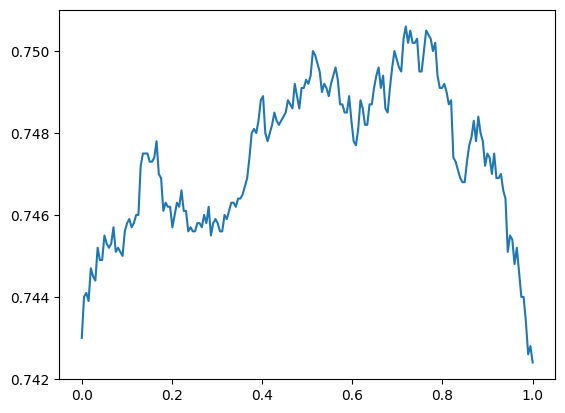

In [111]:
plt.plot('var_smoothing', 'roc_auc_score_mean', data=df_HP, linestyle='-', marker='')
plt.show()

var_smoothing 0.718593 give us max roc accuracy so we create a naive base model with this parameter number.

<hr>

<h2>Double check every thing with the test dataset</h2>

In [112]:
X_test = preprocess(X_test)
X_test = FeatureEngineering(X_test,
                            categorical_variables=categorical_important,
                            numerical_variables=numerical_important,
                            isTrain=False,
                            scaleColumns=numerical_important
                            )

In [113]:
clf_NB = GaussianNB(var_smoothing = 0.718593)
clf_NB.fit(X_train,y_train)
pred = clf_NB.predict(X_test)
roc_auc_score(y_test, pred)

0.7669339811715254

OK<br>
Everything is good, the accuracy of the test dataset is as same as the training dataset, So now we are ready to create our model with all data.

<hr>